In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import pandas as pd
import polars as pl
import utils
from scipy.optimize import least_squares, curve_fit, minimize
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from DataLoader import DataLoader
import datetime as dt
import joblib as joblib

import warnings
warnings.filterwarnings("ignore")

In [108]:
def vix2(ivolData, expiry: int):
    df = ivolData[ivolData['Expiry'] == expiry]
    texp = df['Texp'].values[0]
    mask = ~df['Bid'].isna()
    df = df.loc[mask]

    midVol = 0.5 * (df['Ask'] + df['Bid'])
    fwd = df['Fwd'].values[0]  # Forward price
    strikes = df['Strike']
    k = np.log(strikes / fwd).values  # Log-moneyness
    kmin, kmax = min(k), max(k)
    minvo, maxvo = midVol[k == kmin].values[0], midVol[k == kmax].values[0]

    def volInterp(kout):
        """
        Interpolate vol between strikes;
        set constant outside strike range, use Stineman inside
        """
        if not isinstance(kout, np.ndarray):
            kout = np.array([kout])
        return np.where(
            kout < kmin, minvo,
            np.where(
                kout > kmax, maxvo,
                utils.stineman_interp(k, midVol.values, kout)
            )
        )
    
    # Integrand functions for calls and puts
    def cTilde(y):
        K = np.exp(y)
        vol = volInterp(y)
        price = utils.BSFormula(S=1., K=K, t=texp, r=0, vol=vol, callPutFlag=1)
        return np.exp(y) * price
    
    def pTilde(y):
        K = np.exp(y)
        vol = volInterp(y)
        price = utils.BSFormula(S=1., K=K, t=texp, r=0, vol=vol, callPutFlag=0)
        return np.exp(y) * price
    
    
    # Compute the integrals
    callIntegral, _ = quad(cTilde, 0, 10)
    putIntegral, _ = quad(pTilde, -10, 0)
    
    # Calculate the result
    # res = fwd ** 2 + 2 * (callIntegral + putIntegral)
    res = fwd ** 2 * (1 + 2 * (callIntegral + putIntegral))
    return res


def vix4(ivolData, expiry: int):
    df = ivolData[ivolData['Expiry'] == expiry]
    texp = df['Texp'].values[0]
    mask = ~df['Bid'].isna()
    df = df.loc[mask]

    midVol = 0.5 * (df['Ask'] + df['Bid'])
    fwd = df['Fwd'].values[0]  # Forward price
    strikes = df['Strike']
    k = np.log(strikes / fwd).values  # Log-moneyness
    kmin, kmax = min(k), max(k)
    minvo, maxvo = midVol[k == kmin].values[0], midVol[k == kmax].values[0]

    def volInterp(kout):
        """
        Interpolate vol between strikes;
        set constant outside strike range, use Stineman inside
        """
        if not isinstance(kout, np.ndarray):
            kout = np.array([kout])
        return np.where(
            kout < kmin, minvo,
            np.where(
                kout > kmax, maxvo,
                utils.stineman_interp(k, midVol.values, kout)
            )
        )
    
    # Integrand functions for calls and puts
    def cTilde(y):
        K = np.exp(y)
        vol = volInterp(y)
        price = utils.BSFormula(S=1., K=K, t=texp, r=0, vol=vol, callPutFlag=1)
        return np.exp(3*y) * price
    
    def pTilde(y):
        K = np.exp(y)
        vol = volInterp(y)
        price = utils.BSFormula(S=1., K=K, t=texp, r=0, vol=vol, callPutFlag=0)
        return np.exp(3*y) * price
    
    
    # Compute the integrals
    callIntegral, _ = quad(cTilde, 0, 10)
    putIntegral, _ = quad(pTilde, -10, 0)
    
    # Calculate the result
    # res = fwd ** 2 + 2 * (callIntegral + putIntegral)
    res = fwd ** 4 * (1 + 12 * (callIntegral + putIntegral))
    return res

In [40]:
def sigma_market(ivol_data, expiry: int):
    exp_vix2_mkt = vix2(ivol_data, expiry=expiry) * utils.DELTA / 10**4
    exp_vix4_mkt = vix4(ivol_data, expiry=expiry) * utils.DELTA**2 / 10**8
    return utils.sigma_lognormal(exp_vix2_mkt, exp_vix4_mkt)

def sigma_jacquier(curve: utils.VarianceCurve, volvol: float, hurst: utils.Hurst, T: float):
    exp_vix2_jac = utils.expected_vix_sq(curve)
    exp_vix4_jac = utils.moment2_vix_sq(curve, delta=utils.DELTA, volvol=volvol, hurst=hurst, T=T)
    return utils.sigma_lognormal(exp_vix2_jac, exp_vix4_jac)

def sigma_jim(texp, eta: float, hurst: utils.Hurst):
    return eta**2 * texp**hurst.h2 * utils.f_supH(utils.DELTA / texp, hurst)

In [41]:
def _const_curve(t):
    return np.full(len(t), .234**2) if isinstance(t, np.ndarray) else .234**2

xi_1 = utils.VarianceCurve(_const_curve)

# One day example

In [42]:
params = pl.read_parquet(f"params_20060224_20100101.parquet").rename({'__index_level_0__': 'Date'})

In [43]:
params

shape: (971, 3)
┌──────────┬──────────┬─────────────────────┐
│ H        ┆ eta      ┆ Date                │
│ ---      ┆ ---      ┆ ---                 │
│ f64      ┆ f64      ┆ datetime[ns]        │
╞══════════╪══════════╪═════════════════════╡
│ 0.060874 ┆ 1.24035  ┆ 2006-02-24 00:00:00 │
│ 0.019416 ┆ null     ┆ 2006-02-27 00:00:00 │
│ 0.103102 ┆ 1.246258 ┆ 2006-02-28 00:00:00 │
│ 0.21886  ┆ 1.309458 ┆ 2006-03-01 00:00:00 │
│ 0.031852 ┆ null     ┆ 2006-03-02 00:00:00 │
│ …        ┆ …        ┆ …                   │
│ 0.204327 ┆ 1.488689 ┆ 2009-12-24 00:00:00 │
│ 0.248004 ┆ 1.485507 ┆ 2009-12-28 00:00:00 │
│ 0.300411 ┆ 1.487227 ┆ 2009-12-29 00:00:00 │
│ 0.249737 ┆ 1.508325 ┆ 2009-12-30 00:00:00 │
│ 0.298423 ┆ 1.450311 ┆ 2009-12-31 00:00:00 │
└──────────┴──────────┴─────────────────────┘

In [44]:
loader = DataLoader("./data", "csv")
df = loader.load_dates("20060302", "20060303").to_pandas().set_index('Date')

In [45]:
# Parameters
H = utils.Hurst(0.07)
eta = 1.9
volvol = eta * np.sqrt(H.h2) / (utils.c_h(H) * 2)

In [46]:
single_texp = df.groupby('Texp')['Texp'].count()
single_texp = set(single_texp[single_texp == 1].index)
df = df[~df['Texp'].isin(single_texp)]

In [47]:
df

Expiry      Texp  Strike       Bid       Ask        Fwd  \
Date                                                                        
2006-03-02   2  20060322  0.054795    12.5  0.675188  0.719842  12.127780   
2006-03-02   3  20060322  0.054795    15.0  0.699282  0.988688  12.127780   
2006-03-02   6  20060419  0.131393    10.0  0.461262  0.612153  12.923939   
2006-03-02   7  20060419  0.131393    12.5  0.441717  0.868850  12.923939   
2006-03-02   8  20060419  0.131393    15.0  0.511968  0.883532  12.923939   
2006-03-02  10  20060419  0.131393    20.0  0.660334  1.373205  12.923939   
2006-03-02  12  20060517  0.208105    12.5  0.536310  0.582372  13.693846   
2006-03-02  13  20060517  0.208105    15.0  0.610889  0.755612  13.693846   
2006-03-02  14  20060517  0.208105    17.5  0.330773  0.813087  13.693846   

            CallMid         r  C_Bid  C_Ask  P_Bid  P_Ask  
Date                                                       
2006-03-02    0.625  0.109777   0.60   0.65   0.85   1.00  
2006-03-02    0.200  0.109777   0.10   0.30   2.90   3.20  
2006-03-02    3.000  0.208353   2.80   3.20   0.05   0.15  
2006-03-02    1.450  0.208353   1.30   1.60   0.60   1.35  
2006-03-02    0.600  0.208353   0.30   0.90   2.60   3.10  
2006-03-02    0.425  0.208353   0.05   0.80   7.00   7.50  
2006-03-02    2.250  0.097107   2.10   2.40   0.75   0.85  
2006-03-02    1.175  0.097107   1.00   1.35   2.10   2.75  
2006-03-02    0.450  0.097107   0.05   0.85   3.80   4.80

In [48]:
exp_dates = df['Expiry'].unique()
texp_array = df['Texp'].unique()

In [49]:
df

Expiry      Texp  Strike       Bid       Ask        Fwd  \
Date                                                                        
2006-03-02   2  20060322  0.054795    12.5  0.675188  0.719842  12.127780   
2006-03-02   3  20060322  0.054795    15.0  0.699282  0.988688  12.127780   
2006-03-02   6  20060419  0.131393    10.0  0.461262  0.612153  12.923939   
2006-03-02   7  20060419  0.131393    12.5  0.441717  0.868850  12.923939   
2006-03-02   8  20060419  0.131393    15.0  0.511968  0.883532  12.923939   
2006-03-02  10  20060419  0.131393    20.0  0.660334  1.373205  12.923939   
2006-03-02  12  20060517  0.208105    12.5  0.536310  0.582372  13.693846   
2006-03-02  13  20060517  0.208105    15.0  0.610889  0.755612  13.693846   
2006-03-02  14  20060517  0.208105    17.5  0.330773  0.813087  13.693846   

            CallMid         r  C_Bid  C_Ask  P_Bid  P_Ask  
Date                                                       
2006-03-02    0.625  0.109777   0.60   0.65   0.85   1.00  
2006-03-02    0.200  0.109777   0.10   0.30   2.90   3.20  
2006-03-02    3.000  0.208353   2.80   3.20   0.05   0.15  
2006-03-02    1.450  0.208353   1.30   1.60   0.60   1.35  
2006-03-02    0.600  0.208353   0.30   0.90   2.60   3.10  
2006-03-02    0.425  0.208353   0.05   0.80   7.00   7.50  
2006-03-02    2.250  0.097107   2.10   2.40   0.75   0.85  
2006-03-02    1.175  0.097107   1.00   1.35   2.10   2.75  
2006-03-02    0.450  0.097107   0.05   0.85   3.80   4.80

In [50]:
sigma = np.array([
    sigma_market(df, exp) for exp in exp_dates
])

In [51]:
# def calibration(texps, h, nu):
#     hurst = utils.Hurst(h)

#     sigma_model = np.array([
#         sigma_jacquier(xi_1, nu, hurst, texp) for texp in texps
#     ])
#     return sigma_model


# def calibration_h(texps, h):
#     hurst = utils.Hurst(h)

#     sigma_model = np.array([
#         sigma_jacquier(xi_1, volvol, hurst, texp) for texp in texps
#     ])
#     return sigma_model

In [52]:
def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model


def calibration_h_jim(texps, h):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        sigma_jim(texp, eta, hurst) for texp in texps
    ])
    return sigma_model

In [53]:
params, _ = curve_fit(
    calibration_jim, texp_array, sigma,
    p0=[0.07, eta],
    bounds=([0., 0.], [1., np.inf])
)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [54]:
params_h, _ = curve_fit(
    calibration_h_jim, texp_array, sigma,
    p0=[0.07],
    bounds=(0., 1.)
)

In [ ]:
print(params)
print([params_h.item(), eta])

[0.00854008 6.80837638]
[0.22167257984389474, 1.9]


In [ ]:
sigma_joint = calibration_jim(texp_array, *params)
sigma_h = calibration_h_jim(texp_array, params_h.item())
sigma_hat_0 = calibration_jim(texp_array, H.h, eta)

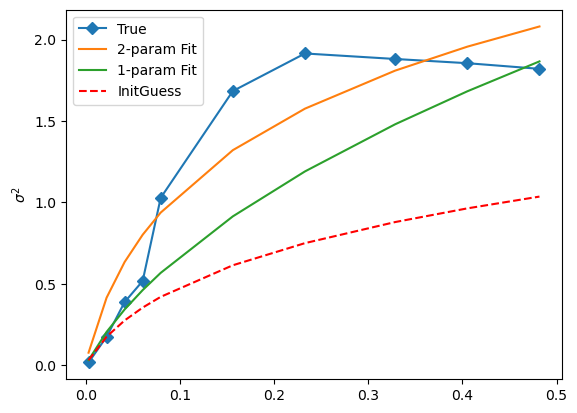

In [ ]:
plt.plot(texp_array, sigma, marker='D', label='True', color='C0')
plt.plot(texp_array, sigma_joint, label='2-param Fit', color='C1')
plt.plot(texp_array, sigma_h, label='1-param Fit', color='C2')
plt.plot(texp_array, sigma_hat_0, color='red', ls='--', label='InitGuess')
plt.ylabel(r"$\sigma^2$")
plt.legend()
plt.show()

In [ ]:
[r2_score(sigma, pred) for pred in (sigma_joint, sigma_h)]

[0.9031053857510027, 0.7259560461363841]

# Everyday I'm hustling

In [130]:
start, end = "20060224", "20230831"

In [131]:
loader = DataLoader("./data", "csv")
df = loader.load_dates(start, end).sort('Date')[:, 1:]

In [133]:
df

shape: (916_781, 8)
┌──────────┬──────────┬────────┬──────────┬──────────┬───────────┬──────────┬─────────────────────┐
│ Expiry   ┆ Texp     ┆ Strike ┆ Bid      ┆ Ask      ┆ Fwd       ┆ CallMid  ┆ Date                │
│ ---      ┆ ---      ┆ ---    ┆ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---                 │
│ i64      ┆ f64      ┆ f64    ┆ f64      ┆ f64      ┆ f64       ┆ f64      ┆ datetime[ns]        │
╞══════════╪══════════╪════════╪══════════╪══════════╪═══════════╪══════════╪═════════════════════╡
│ 20060322 ┆ 0.071233 ┆ 12.5   ┆ 0.397999 ┆ 0.751937 ┆ 12.251797 ┆ 0.625    ┆ 2006-02-24 00:00:00 │
│ 20060322 ┆ 0.071233 ┆ 15.0   ┆ 0.500455 ┆ 0.667055 ┆ 12.251797 ┆ 0.1      ┆ 2006-02-24 00:00:00 │
│ 20060419 ┆ 0.147831 ┆ 12.5   ┆ 0.346001 ┆ 0.533366 ┆ 12.99698  ┆ 1.3      ┆ 2006-02-24 00:00:00 │
│ 20060419 ┆ 0.147831 ┆ 15.0   ┆ 0.46873  ┆ 0.758272 ┆ 12.99698  ┆ 0.55     ┆ 2006-02-24 00:00:00 │
│ 20060419 ┆ 0.147831 ┆ 17.5   ┆ 0.590799 ┆ 1.052294 ┆ 12.99698  ┆ 0.475    ┆ 2006-02-24 00:00:00 │
│ …        ┆ …        ┆ …      ┆ …        ┆ …        ┆ …         ┆ …        ┆ …                   │
│ 20240522 ┆ 0.728268 ┆ 110.0  ┆ 0.899486 ┆ 0.960186 ┆ 20.297357 ┆ 0.213034 ┆ 2023-08-30 00:00:00 │
│ 20240522 ┆ 0.728268 ┆ 120.0  ┆ 0.917649 ┆ 0.977613 ┆ 20.297357 ┆ 0.187055 ┆ 2023-08-30 00:00:00 │
│ 20240522 ┆ 0.728268 ┆ 130.0  ┆ 0.930241 ┆ 0.996458 ┆ 20.297357 ┆ 0.166271 ┆ 2023-08-30 00:00:00 │
│ 20240522 ┆ 0.728268 ┆ 140.0  ┆ 0.937205 ┆ 1.01872  ┆ 20.297357 ┆ 0.150683 ┆ 2023-08-30 00:00:00 │
│ 20240522 ┆ 0.728268 ┆ 150.0  ┆ 0.951014 ┆ 1.030239 ┆ 20.297357 ┆ 0.135095 ┆ 2023-08-30 00:00:00 │
└──────────┴──────────┴────────┴──────────┴──────────┴───────────┴──────────┴─────────────────────┘

In [134]:
dates = df['Date'].unique().to_list()

In [135]:
exp_count = df.group_by(['Date', 'Texp'], maintain_order=True).len().group_by('Date', maintain_order=True).min()
opt_count = df.group_by('Date', maintain_order=True).len()

In [136]:
# Parameters
H = utils.Hurst(0.07)
eta = 1.9
volvol = eta * np.sqrt(H.h2) / (utils.c_h(H) * 2)

def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model


def calibration_h_jim(texps, h):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        sigma_jim(texp, eta, hurst) for texp in texps
    ])
    return sigma_model

In [137]:
def calibrate_one_day(dd):
    _df = df.filter(pl.col('Date') == dd).to_pandas().set_index('Date')
    if _df.empty:
        return np.array([np.nan, np.nan])
    # address expirations with single obs
    single_texp = _df.groupby('Texp')['Texp'].count()
    single_texp = set(single_texp[single_texp == 1].index)
    _df = _df[~_df['Texp'].isin(single_texp)]
    
    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    # true values
    sigma = np.array([
        sigma_market(_df, exp) for exp in exp_dates
    ])

    # calibrate - we try 2-parameter calibration and if it fails
    # we just fit H
    obj = lambda x: np.sum((calibration_jim(texp_array, x[0], x[1]) - sigma)**2)
    opt = minimize(
        obj, np.array([0.07, eta]),
        method='L-BFGS-B',
        bounds=((0., 1.), (1., None))
    )
    if opt.success:
        params = opt.x
        params = np.concatenate((opt.x, [0.0]))
    else:
        print(f"CAPRA!!!!! NON SAI FARE NULLA! ({dd})")
    # params, _ = curve_fit(
    #     calibration_jim, texp_array, sigma,
    #     p0=[0.07, eta],
    #     bounds=([0., 0.], [1., np.inf])
    # )
        obj = lambda x: np.sum((calibration_h_jim(texp_array, x[0]) - sigma)**2)
        opt = minimize(
            obj, np.array([0.07]),
            method='L-BFGS-B',
            bounds=[(0., 1.)]
        )
        if not opt.success:
            #print(f"CAPRA!!!!! NON SAI FARE PROPRIO NULLA! ({dd})rrr")
            arr = np.empty(2) * np.nan
            params = np.concatenate((arr, [2.0]))
        # params, _ = curve_fit(
        #     calibration_h_jim, texp_array, sigma,
        #     p0=[0.07],
        #     bounds=(0., 1.)
        # )
        else:
            params = np.concatenate((opt.x, [np.nan], [1.0]))
    
    return params
    

In [138]:
calibrated_params = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(calibrate_one_day)(dd) for dd in dates
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   16.5s


CAPRA!!!!! NON SAI FARE NULLA! (2006-06-15 00:00:00)


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   53.1s


CAPRA!!!!! NON SAI FARE NULLA! (2006-12-18 00:00:00)


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  1.2min


CAPRA!!!!! NON SAI FARE NULLA! (2007-03-07 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2007-03-21 00:00:00)


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.4min


CAPRA!!!!! NON SAI FARE NULLA! (2007-03-26 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2007-03-29 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  1.8min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


CAPRA!!!!! NON SAI FARE NULLA! (2007-07-09 00:00:00)


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min


CAPRA!!!!! NON SAI FARE NULLA! (2007-08-13 00:00:00)


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.5min


CAPRA!!!!! NON SAI FARE NULLA! (2008-10-03 00:00:00)


[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  3.8min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.0min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivis

CAPRA!!!!! NON SAI FARE NULLA! (2009-01-29 00:00:00)


[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  4.3min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probabl

CAPRA!!!!! NON SAI FARE NULLA! (2010-02-18 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2010-05-19 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2010-08-02 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2010-09-17 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  T

CAPRA!!!!! NON SAI FARE NULLA! (2011-03-24 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2011-06-14 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2011-08-10 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2011-08-24 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2012-01-04 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2012-01-09 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2012-02-15 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2012-02-16 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2012-04-16 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 10.5min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probab

CAPRA!!!!! NON SAI FARE NULLA! (2012-04-25 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2012-08-23 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2012-08-30 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2012-11-13 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2012-12-06 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2013-06-17 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
[Parallel(n_jobs=-1)]: Done 1845 tasks      | elapsed: 13.1min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probab

CAPRA!!!!! NON SAI FARE NULLA! (2013-06-26 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2013-08-19 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2013-08-29 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2013-10-29 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2013-11-07 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

CAPRA!!!!! NON SAI FARE NULLA! (2013-12-18 00:00:00)


[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 14.2min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probab

CAPRA!!!!! NON SAI FARE NULLA! (2014-01-29 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2014-06-20 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
[Parallel(n_jobs=-1)]: Done 2097 tasks      | elapsed: 15.2min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probab

CAPRA!!!!! NON SAI FARE NULLA! (2014-08-25 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2014-12-15 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2014-12-17 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

CAPRA!!!!! NON SAI FARE NULLA! (2014-12-19 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2015-05-07 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


CAPRA!!!!! NON SAI FARE NULLA! (2015-05-06 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

CAPRA!!!!! NON SAI FARE NULLA! (2015-06-19 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2015-12-18 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2016-09-15 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2016-09-26 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2016-11-01 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2016-11-10 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2017-04-17 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2017-06-12 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2017-06-22 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2017-12-05 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-02-21 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-02-20 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


CAPRA!!!!! NON SAI FARE NULLA! (2018-02-27 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-03-05 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2018-03-02 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-03-22 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2018-03-26 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-05-04 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-05-18 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-05-29 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-06-20 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2018-06-19 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

CAPRA!!!!! NON SAI FARE NULLA! (2018-09-27 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-10-01 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2018-10-25 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2019-08-26 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2019-09-20 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


CAPRA!!!!! NON SAI FARE NULLA! (2019-09-24 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2020-04-06 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

CAPRA!!!!! NON SAI FARE NULLA! (2020-04-15 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2020-11-19 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-02-09 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-03-02 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-03-23 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-04-23 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

CAPRA!!!!! NON SAI FARE NULLA! (2021-05-04 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-06-07 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-06-11 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-06-18 00:00:00)


[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 35.8min
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probab

CAPRA!!!!! NON SAI FARE NULLA! (2021-07-20 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2021-07-21 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-

CAPRA!!!!! NON SAI FARE NULLA! (2021-07-28 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-08-05 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

CAPRA!!!!! NON SAI FARE NULLA! (2021-08-19 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-08-25 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-09-14 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-10-06 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-10-26 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-11-01 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2021-11-04 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2021-11-12 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  T

CAPRA!!!!! NON SAI FARE NULLA! (2021-12-21 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2022-01-13 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2022-02-09 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2022-02-10 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2022-03-02 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

CAPRA!!!!! NON SAI FARE NULLA! (2022-03-15 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2022-03-18 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2022-10-10 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2022-10-11 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2023-03-21 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2023-05-23 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2023-05-26 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

CAPRA!!!!! NON SAI FARE NULLA! (2023-08-15 00:00:00)


/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:96: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/z_/x9wlp7312jq6twc_v90kt5ww0000gn/T/ipykernel_3077/1438970362.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it i

In [ ]:
calibrated_params = []  # [calibrate_one_day(dd) for dd in tqdm(dates)]
for dd in tqdm(dates):
    try:
        calibrated_params.append(calibrate_one_day(dd))
    except IndexError:
        calibrated_params.append([np.nan, np.nan])
        print(dd, dd, dd)

 16%|█▋        | 35/215 [00:19<01:42,  1.76it/s]


KeyboardInterrupt: 

# Analyze

In [139]:
params = pd.DataFrame(calibrated_params, columns=['H', 'eta', 'err_code'], index=dates)
params.describe()

H          eta     err_code
count  4409.000000  4302.000000  4409.000000
mean      0.052308    20.030346     0.024269
std       0.077726    20.556480     0.153899
min       0.000045     1.020791     0.000000
25%       0.000212     2.222176     0.000000
50%       0.002851    11.690711     0.000000
75%       0.084064    34.274953     0.000000
max       1.000000   134.606600     1.000000

In [141]:
params.loc[params['err_code']==1]

H  eta  err_code
2006-06-15  0.066362  NaN       1.0
2006-12-18  0.041968  NaN       1.0
2007-03-07  0.046755  NaN       1.0
2007-03-21  0.047991  NaN       1.0
2007-03-26  0.047971  NaN       1.0
...              ...  ...       ...
2022-10-11  0.239547  NaN       1.0
2023-03-21  0.250218  NaN       1.0
2023-05-23  0.250838  NaN       1.0
2023-05-26  0.257834  NaN       1.0
2023-08-15  0.262478  NaN       1.0

[107 rows x 3 columns]

In [ ]:
params.to_c('')

In [152]:
params.fillna(eta).describe()

H          eta     err_code
count  4409.000000  4409.000000  4409.000000
mean      0.052308    19.590349     0.024269
std       0.077726    20.496265     0.153899
min       0.000045     1.020791     0.000000
25%       0.000212     2.122018     0.000000
50%       0.002851     9.107274     0.000000
75%       0.084064    33.907436     0.000000
max       1.000000   134.606600     1.000000

In [89]:
params.dropna().describe()

H         eta  err_code
count  213.000000  213.000000     213.0
mean     0.094763    8.363122       0.0
std      0.086907   11.486874       0.0
min      0.000076    1.050331       0.0
25%      0.001039    1.317468       0.0
50%      0.092759    1.635737       0.0
75%      0.156960   13.627962       0.0
max      0.321317   43.621108       0.0

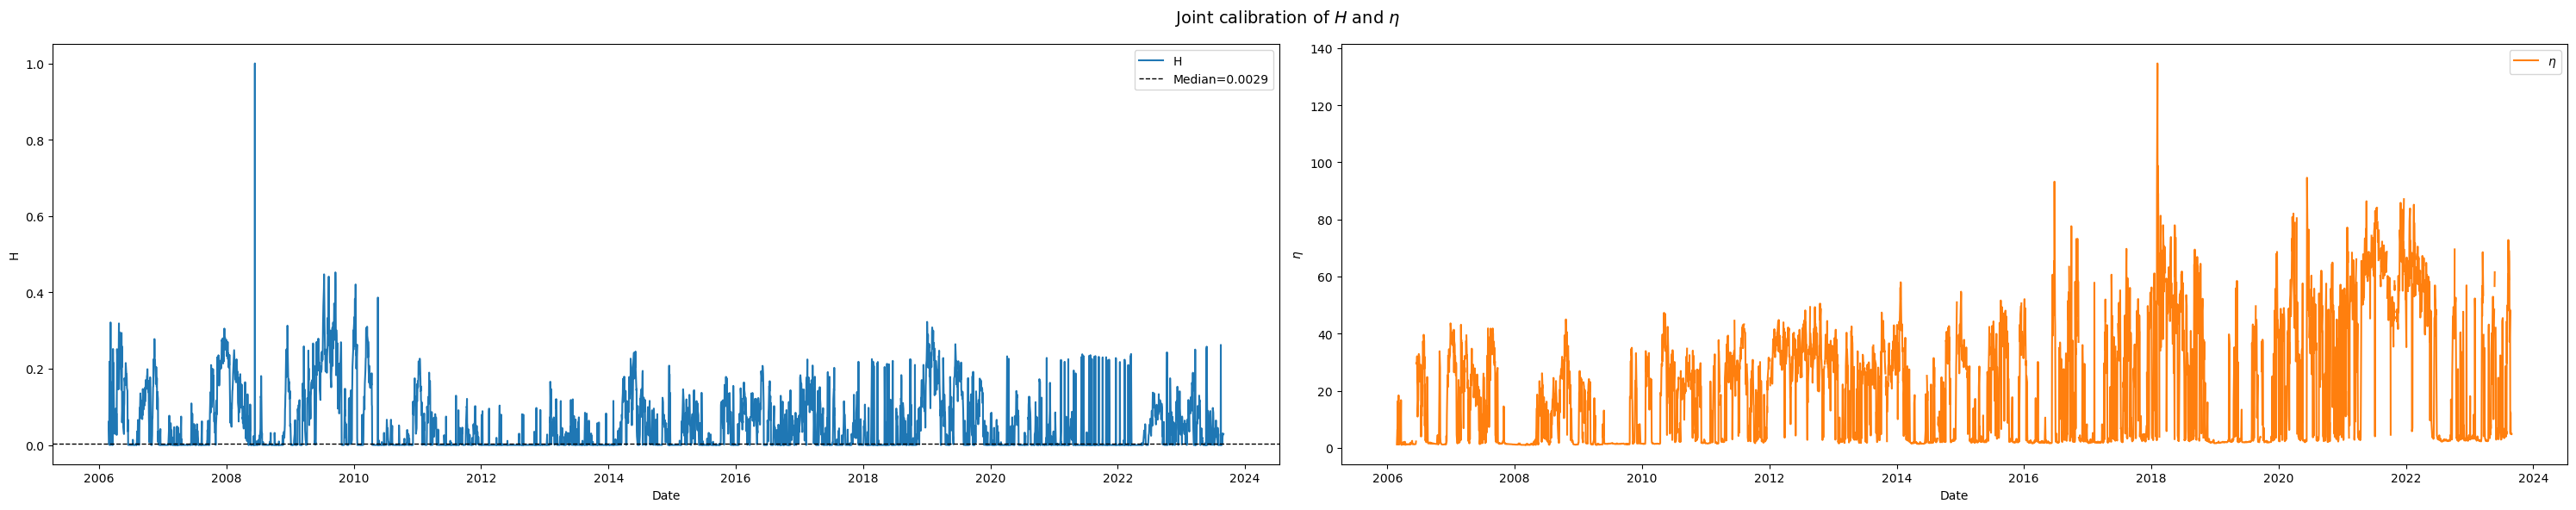

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'], label='H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'], label=r'$\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")

fig.tight_layout()
plt.savefig(f"./Plots/calibrated_params_{start}_{end}.png")
plt.show()

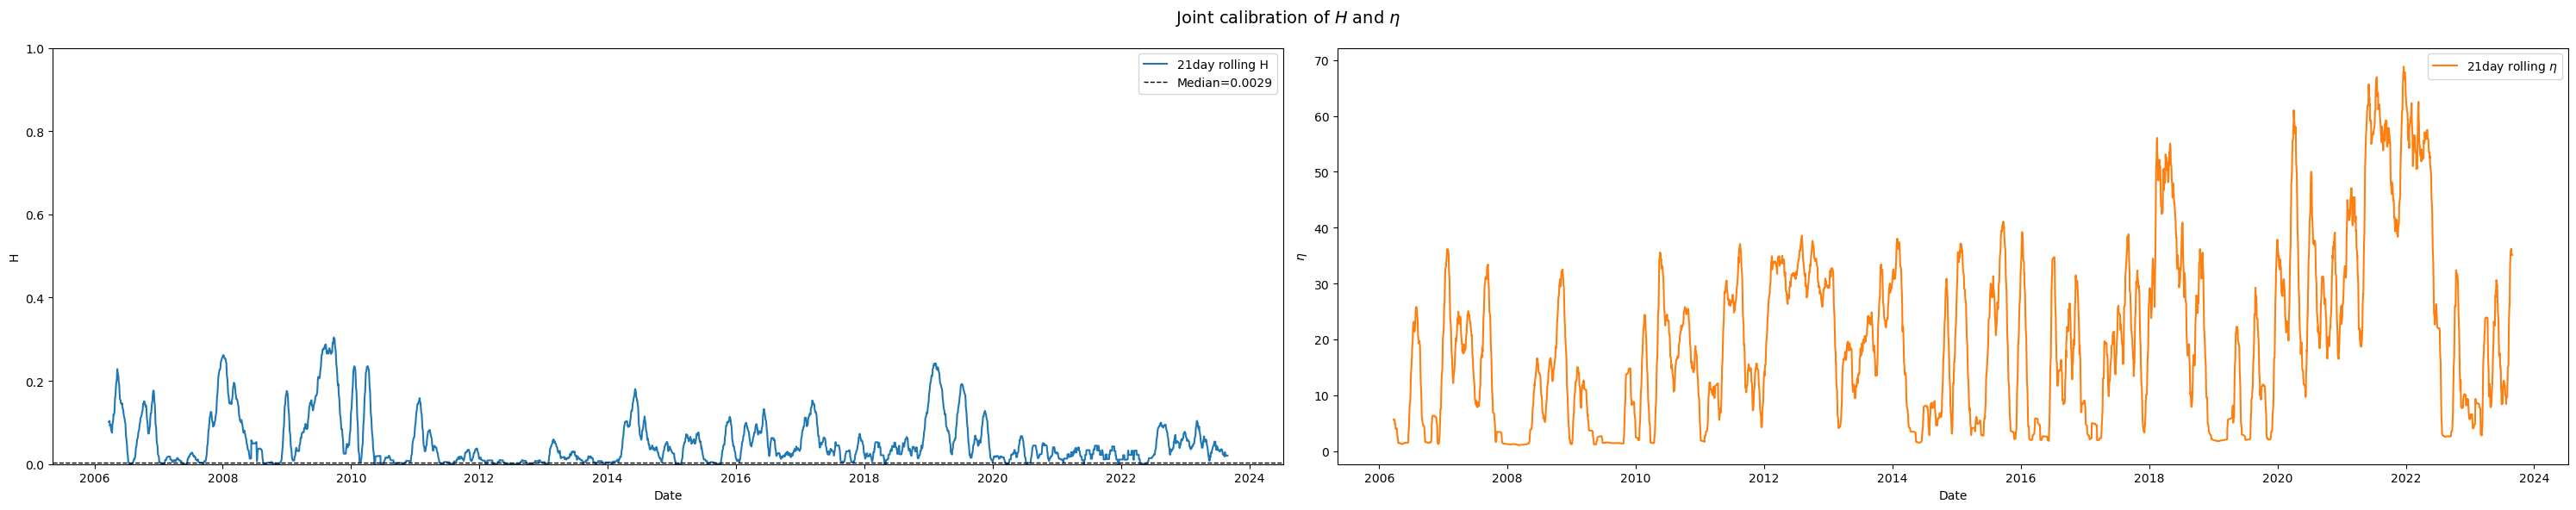

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'].rolling(21).mean(), label='21day rolling H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'].fillna(1.9).rolling(21).mean(), label=r'21day rolling $\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
axs[0].set_ylim(0, 1)
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")

fig.tight_layout()
plt.show()

In [142]:
params.to_parquet(f"params_{start}_{end}.parquet")